## Imports

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

np.random.seed(0)
torch.manual_seed(0)

## Making and visualizing the dataset

In [93]:
N = 200

X = torch.rand(2 * N, 2) * 10 - 5
X_train = X[:N]
X_test = X[N:]
y_train = ((X_train[:, 0] * X_train[:, 1]) > 0).to(torch.float32).view(-1, 1)
y_test = ((X_test[:, 0] * X_test[:, 1]) > 0).to(torch.float32).view(-1, 1)

# Add some noise
X_train += torch.randn_like(X_train) * 0.1
X_test += torch.randn_like(X_test) * 0.1

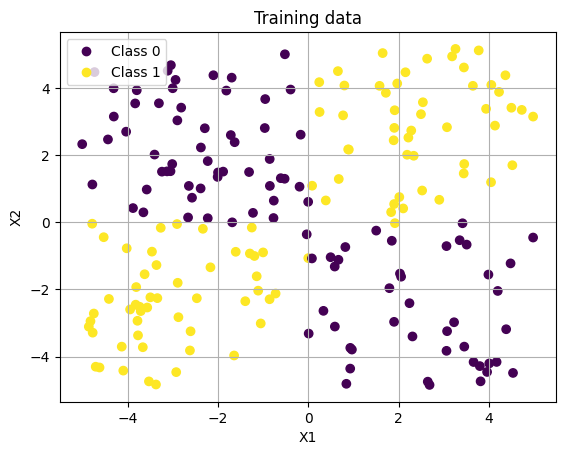

In [94]:
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.title("Training data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid()
plt.show()

## Utility Functions

In [95]:
def train(model, epochs, lr, l1_reg, l2_reg, **kwargs):
	optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
	loss_fn = torch.nn.BCELoss()

	for epoch in range(epochs):
		optimizer.zero_grad()
		y_pred = model(X_train, **kwargs)
		loss = loss_fn(y_pred, y_train)

		if l1_reg > 0:
			loss += l1_reg * sum(p.abs().sum() for p in model.parameters())

		loss.backward()
		optimizer.step()
		if epoch % (epochs // 10) == 0:
			print(f"Epoch {epoch}: loss = {loss.item()}")

def plot_decision_boundary(model, X, y, res=100, **kwargs):
    x_min, x_max = -6, 6
    y_min, y_max = -6, 6
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, res), np.linspace(y_min, y_max, res))
    points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    with torch.no_grad():
        Z = model(points, **kwargs).reshape(xx.shape).numpy()

    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=["blue", "red"])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolor="k")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Decision Boundary")
    plt.show()

## Comparing the performance of the models

### Simple MLP

In [96]:
class MLP(nn.Module):
	def __init__(self):
		super(MLP, self).__init__()
		self.fc1 = nn.Linear(2, 10)
		self.fc2 = nn.Linear(10, 1)
		self.act1 = nn.ReLU()
		self.act2 = nn.Sigmoid()

	def forward(self, x):
		x = self.act1(self.fc1(x))
		x = self.act2(self.fc2(x))
		return x

Epoch 0: loss = 0.7347175478935242
Epoch 500: loss = 0.03218695521354675
Epoch 1000: loss = 0.015638161450624466
Epoch 1500: loss = 0.008404872380197048
Epoch 2000: loss = 0.004628452472388744
Epoch 2500: loss = 0.002630804665386677
Epoch 3000: loss = 0.001570007298141718
Epoch 3500: loss = 0.000981367425993085
Epoch 4000: loss = 0.0006370277842506766
Epoch 4500: loss = 0.0004258507105987519


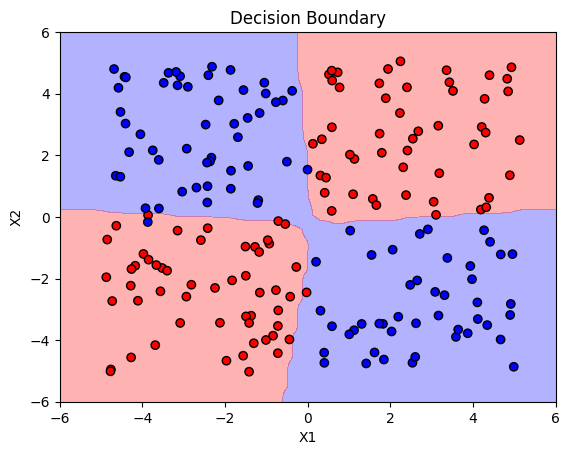

In [97]:
model = MLP()
train(model, epochs=5000, lr=0.01, l1_reg=0, l2_reg=0)
plot_decision_boundary(model, X_test, y_test)

### MLP + L1 Regularization

Epoch 0: loss = 0.7959901690483093
Epoch 500: loss = 0.2362717092037201
Epoch 1000: loss = 0.2351350039243698
Epoch 1500: loss = 0.23500949144363403
Epoch 2000: loss = 0.2350189983844757
Epoch 2500: loss = 0.23510394990444183
Epoch 3000: loss = 0.23501840233802795
Epoch 3500: loss = 0.23504501581192017
Epoch 4000: loss = 0.23505830764770508
Epoch 4500: loss = 0.23508241772651672


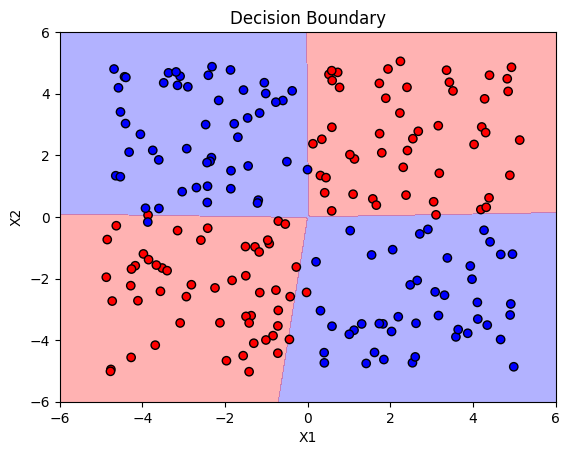

In [98]:
model = MLP()
train(model, epochs=5000, lr=0.01, l1_reg=0.01, l2_reg=0)
plot_decision_boundary(model, X_test, y_test)

### MLP + L2 Regularization

Epoch 0: loss = 0.7200140357017517
Epoch 500: loss = 0.09584438055753708
Epoch 1000: loss = 0.09552394598722458
Epoch 1500: loss = 0.09551455825567245
Epoch 2000: loss = 0.09551398456096649
Epoch 2500: loss = 0.09551432728767395
Epoch 3000: loss = 0.09551314264535904
Epoch 3500: loss = 0.09551723301410675
Epoch 4000: loss = 0.09552712738513947
Epoch 4500: loss = 0.09552335739135742


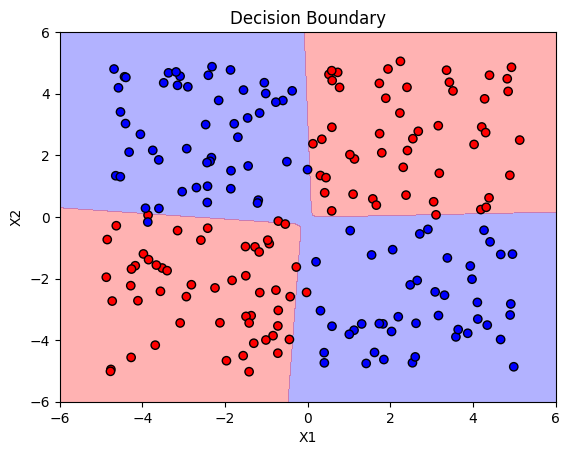

In [99]:
model = MLP()
train(model, epochs=5000, lr=0.01, l1_reg=0, l2_reg=0.01)
plot_decision_boundary(model, X_test, y_test)

### Logistic Regression with different features

#### Logistic Regression with features X1, X2 only

In [100]:
class LogisticRegression(nn.Module):
	def __init__(self, features):
		super().__init__()
		self.fc = nn.Linear(features, 1)
		self.act = nn.Sigmoid()

	def forward(self, x, selected_features=[0, 1]):
		X = torch.cat([x, x ** 2, (x[:, 0] * x[:, 1]).view(-1, 1)], dim=1)[:, selected_features]
		return self.act(self.fc(X))

Epoch 0: loss = 0.7152947187423706
Epoch 100: loss = 0.6966071128845215
Epoch 200: loss = 0.6931764483451843
Epoch 300: loss = 0.6929323673248291
Epoch 400: loss = 0.6929261684417725
Epoch 500: loss = 0.6929261684417725
Epoch 600: loss = 0.6929261088371277
Epoch 700: loss = 0.6929261684417725
Epoch 800: loss = 0.6929261684417725
Epoch 900: loss = 0.6929261684417725


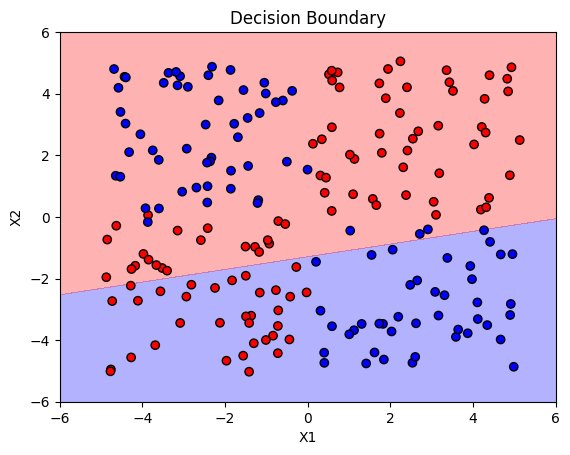

In [101]:
model = LogisticRegression(2)
train(model, epochs=1000, lr=0.001, l1_reg=0, l2_reg=0)
plot_decision_boundary(model, X_test, y_test)

#### Logistic Regression with features X1^2, X2^2

Epoch 0: loss = 10.117301940917969
Epoch 1000: loss = 0.10161882638931274
Epoch 2000: loss = 0.07498549669981003
Epoch 3000: loss = 0.06135448068380356
Epoch 4000: loss = 0.05230683460831642
Epoch 5000: loss = 0.04565917328000069
Epoch 6000: loss = 0.0405544713139534
Epoch 7000: loss = 0.03656698390841484
Epoch 8000: loss = 0.03344307467341423
Epoch 9000: loss = 0.0310037974268198


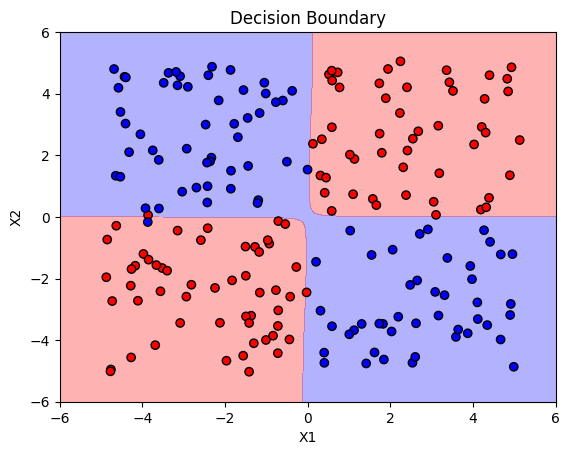

In [102]:
model = LogisticRegression(2)
train(model, epochs=10000, lr=0.01, l1_reg=0, l2_reg=0, selected_features=[3, 4])
plot_decision_boundary(model, X_test, y_test, selected_features=[3, 4])

#### Logistic Regression with X1 * X2 as a feature

Epoch 0: loss = 5.983279228210449
Epoch 1000: loss = 0.12746202945709229
Epoch 2000: loss = 0.09340027719736099
Epoch 3000: loss = 0.07629101723432541
Epoch 4000: loss = 0.06501242518424988
Epoch 5000: loss = 0.056693825870752335
Epoch 6000: loss = 0.05021243914961815
Epoch 7000: loss = 0.04500862956047058
Epoch 8000: loss = 0.04075261950492859
Epoch 9000: loss = 0.03723403811454773


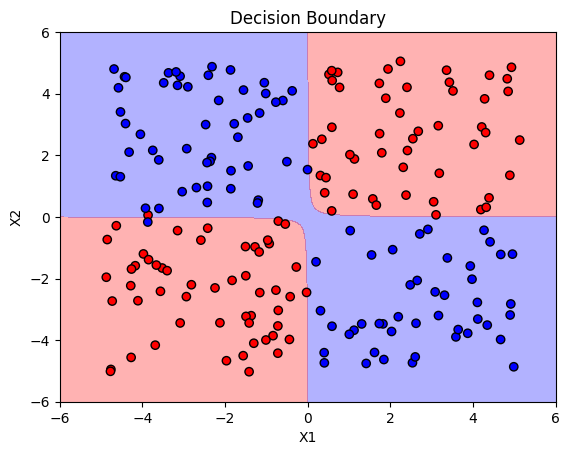

In [103]:
model = LogisticRegression(1)
train(model, epochs=10000, lr=0.01, l1_reg=0, l2_reg=0, selected_features=[4])
plot_decision_boundary(model, X_test, y_test, selected_features=[4])

#### Logistic Regression with X1, X2, X1^2, X2^2, X1 * X2 as features

Epoch 0: loss = 2.634404182434082
Epoch 1000: loss = 0.08507555723190308
Epoch 2000: loss = 0.06222391128540039
Epoch 3000: loss = 0.051569223403930664
Epoch 4000: loss = 0.04492141306400299
Epoch 5000: loss = 0.0401337705552578
Epoch 6000: loss = 0.036410413682460785
Epoch 7000: loss = 0.03338928148150444
Epoch 8000: loss = 0.030869154259562492
Epoch 9000: loss = 0.02871205098927021


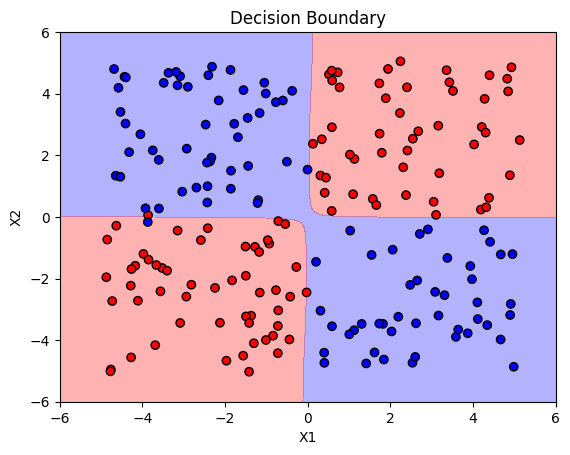

In [104]:
model = LogisticRegression(5)
train(model, epochs=10000, lr=0.01, l1_reg=0, l2_reg=0, selected_features=[0, 1, 2, 3, 4])
plot_decision_boundary(model, X_test, y_test, selected_features=[0, 1, 2, 3, 4])